In [23]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
from keras.utils import np_utils

In [24]:
import cv2,os

data_path='../input/dataset/dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [25]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [26]:
from keras.utils import np_utils
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)
new_target=np_utils.to_categorical(target)

np.save('data',data)
np.save('target',new_target)

In [27]:

import numpy as np

data=np.load('../input/data-target/data.npy')
target=np.load('../input/data-target/target.npy')

In [28]:
model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [30]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
31/31 [==============================] - 48s 2s/step - loss: 0.7150 - accuracy: 0.5781 - val_loss: 0.5673 - val_accuracy: 0.6653
Epoch 2/20
31/31 [==============================] - 47s 2s/step - loss: 0.4909 - accuracy: 0.7737 - val_loss: 0.4154 - val_accuracy: 0.8185
Epoch 3/20
31/31 [==============================] - 47s 2s/step - loss: 0.3152 - accuracy: 0.8788 - val_loss: 0.2846 - val_accuracy: 0.8952
Epoch 4/20
31/31 [==============================] - 47s 2s/step - loss: 0.2327 - accuracy: 0.9097 - val_loss: 0.2368 - val_accuracy: 0.9234
Epoch 5/20
31/31 [==============================] - 48s 2s/step - loss: 0.1702 - accuracy: 0.9257 - val_loss: 0.1995 - val_accuracy: 0.9153
Epoch 6/20
31/31 [==============================] - 47s 2s/step - loss: 0.1021 - accuracy: 0.9600 - val_loss: 0.1936 - val_accuracy: 0.9234
Epoch 7/20
31/31 [==============================] - 47s 2s/step - loss: 0.0862 - accuracy: 0.9700 - val_loss: 0.1504 - val_accuracy: 0.9476
Epoch 8/20
31/31 [==

In [31]:
import os
import numpy as np
import requests
yolo_config = '../input/yolov3/yolov3-spp.cfg'
yolo_weights = '../input/yolov3/yolov3-spp.weights'
classes_file = '../input/coco-names/coco.names'

with open(classes_file,'r') as f:
    classes=[line.strip() for line in f.readlines()]
   
net=cv2.dnn.readNet(yolo_weights,yolo_config)

def humanDetect(image):
   
    blob=cv2.dnn.blobFromImage(image,1/255,(512,512),(0,0,0),True,crop=False)
    
    net.setInput(blob)
    layer_names=net.getLayerNames()
    output_layers=[layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
    outs=net.forward(output_layers)
    class_ids= list()
    confidences= list()
    boxes= list()

    for out in outs:
        # iterate over anchor boxes for human class
        for detection in out:
            #bounding box
            center_x=int(detection[0] * image.shape[1])
            center_y=int(detection[1] * image.shape[0])
            w=int(detection[2] * image.shape[1])
            h=int(detection[3] * image.shape[0])
            x=center_x - w // 2
            y=center_y - h // 2
            boxes.append([x,y,w,h])
            
            #class
            class_id=np.argmax(detection[5:])
            class_ids.append(class_id)
            confidence=detection[4]
            confidences.append(float(confidence))
   
    #non-max supression
    ids=cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.3)
    #draw the bounding boxes on the image
    colors= np.random.uniform(0,255,size=(len(classes),3))

    imgs = []

    for i in ids:
        i=i[0]
        x,y,w,h=boxes[i]
        class_id=class_ids[i]
        color=colors[class_id]
        if classes[class_id]=='person':
            crop= image[y:y+h,x:x+w]
            imgs.append([crop, [x, y, w, h]])           
            # return [crop, [x, y, w, h]]

    if (len(imgs) == 0):
      return None
    else: 
      return imgs 

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
face_clsfr=cv2.CascadeClassifier('../input/viola/haarcascade_frontalface_alt.xml')

In [33]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import requests

#importing dependencies related to nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#importing dependencies related to image transformations
import torchvision
from torchvision import transforms
from PIL import Image

#importing dependencies related to data loading
from torchvision import datasets
from torch.utils.data import DataLoader
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
model = torch.hub.load('pytorch/vision:v0.6.0', 'shufflenet_v2_x1_0', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [34]:
import torchvision
from torchvision import transforms
import numpy as np 
import cv2 
import time 
import requests
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow
layers = tensorflow.keras.layers
BatchNormalization = tensorflow.keras.layers.BatchNormalization
Conv2D = tensorflow.keras.layers.Conv2D
Flatten = tensorflow.keras.layers.Flatten
TensorBoard = tensorflow.keras.callbacks.TensorBoard
ModelCheckpoint = tensorflow.keras.callbacks.ModelCheckpoint
from tensorflow.keras import datasets, layers, models
from tensorflow import keras

transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])])
transform = transforms.ToTensor()
model.eval()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [35]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from PIL import Image

from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cap = cv2.VideoCapture('../input/youtubevideo/Children interrupt BBC News interview - BBC News.mp4')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

out = cv2.VideoWriter('./output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 20, (frame_width,frame_height))


frame_index = 0

# Reading the video file until finished 
while(True): 

    frame_index = frame_index + 1

    ret, frame = cap.read() 
    # if video finished or no Video Input 
    if not ret: 
        break

    if (frame_index % 3 != 0):
      continue

    # detect human 
    tmpFrm = np.copy(frame)
    imgs_and_coords = humanDetect(tmpFrm) 

    if imgs_and_coords == None:
      continue

    for i in range(len(imgs_and_coords)):

        [img, coords] = imgs_and_coords[i]

        if 0 in (img.shape):
          continue

        # detect face
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_clsfr.detectMultiScale(gray,1.3,3)

        if len(faces) > 0:
          for (x,y,w,h) in faces:
            face_img = img[y:y+h,x:x+w]
            break
        else:
          face_img = img

        face_img = transform(face_img)
        face_img = torch.stack([face_img])
        face_img = face_img.to(device)

        result = model(face_img)
        _, predicted = torch.max(result.data, 1)

        x, y, w, h = coords

        if predicted>=0.5:
          cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), thickness=2)
          cv2.putText(frame, "No mask", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 4, cv2.LINE_AA) 
        else:
          cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), thickness=2)
          cv2.putText(frame, "Mask", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 4, cv2.LINE_AA) 

        out.write(frame)

# When everything done, release the capture 
cap.release() 
# Destroy the all windows now 
#cv2.destroyAllWindows() 

tensor([761])


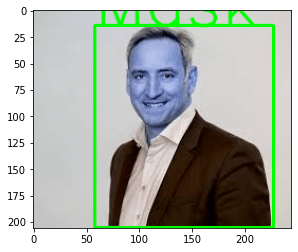

In [42]:
frame = cv2.imread("../input/without-mask/without_mask.png")
#frame = cv2.imread("../input/covid-mask/mask.png")
# frame = cv2.imread("/content/drive/MyDrive/Colab Notebooks/VR/MiniProject/covid-mask-distancing.jpeg")

tmpFrm = np.copy(frame)

final = []


transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])])
transform = transforms.ToTensor()

model.eval()



# detect human 
# [imgs, coords] = humanDetect(frame) 
imgs_and_coords = humanDetect(tmpFrm) 

for i in range(len(imgs_and_coords)):

  # if i != 4:
  #   continue

  [img, coords] = imgs_and_coords[i]
  
  if 0 in (img.shape):
    continue

  # detect face
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_clsfr.detectMultiScale(gray,1.3,3)

  if len(faces) > 0:
    for (x,y,w,h) in faces:
      face_img = img[y:y+h,x:x+w]
      break
  else:
    face_img = img

  face_img = transform(face_img)
  face_img = torch.stack([face_img])
  face_img = face_img.to(device)
  result = model(face_img)
  _, predicted = torch.max(result.data, 1)
  final.append(result.data)

  x, y, w, h = coords
  if predicted==1:
    cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), thickness=2)
    cv2.putText(frame, "No mask", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA) 
  else:
    cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), thickness=2)
    cv2.putText(frame, "Mask", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA) 
print(predicted)
plt.imshow(frame)